<a href="https://colab.research.google.com/github/YovliDuvshani/RideHailling/blob/main/Ride_Hailing_Sing_Duvshani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Install

!pip install pyhailing #Restart runtime
!pip install --upgrade Pillow #Restart runtime

In [48]:
# Import 

import torch.nn as nn
import torch
import numpy
import numpy as np #To improve
import pyhailing
from pyhailing import RidehailEnv
import tqdm
import random
from collections import OrderedDict
import time as t
import torch.nn.functional as F
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pickle
import time as __time__
from scipy import stats

random.seed(2)
torch.manual_seed(2)
numpy.random.seed(2)

#### Documentation 
**What's the general idea of this code ?**
* Env_config : sets the simulation environment in the appropriate configuration

* Distance functions : contains all the functions that aims at estimating riding distances or riding durations in the environment, whether these functions are based on mean estimations or probalistic estimations

* Environment : contains functions that aims at defining some basic notations in order to simplify the environment representation, also contains the request distribution per 15minutes for the small configuration (for other configurations the distribution just gets multiplied by a coefficient)

* Heuristic functions : contains 2 different repositioning heuristics that we tested, the basic one where we relocate the jobless cars; and a more complex one which is more detailled in the corresponding section

* Q-learning algorithm : we used two different DeepQ Learning models; one that receives global inputs and cars inputs, then returns Q-values associated to the car to assign to the request or to the no assignment option, and one that only receives global inputs and decides whether or not the request should be assigned, then the car the most likely to arrive before 5 minutes takes the request (if decided that the request should be assigned).
An other one is not yet functional and use the advantage concept.

* Main : training loops and results are available in this section
There are 2 different mains one for the general use and an other specific main for what we call the 'DistilQ Algorithm'. 

***Every relevant section is also documented in this notebook***

## Env_Config

In [49]:
# Size of the environnment

size = 1 #1:small, 2:medium, 3:large
if size==1:
  env_config = RidehailEnv.DIMACS_CONFIGS.SUI
  env_config['nickname'] = 'mynickname'
elif size==2:
  env_config = RidehailEnv.DIMACS_CONFIGS.MUI
  env_config['nickname'] = 'mynickname'
else:
  env_config = RidehailEnv.DIMACS_CONFIGS.LUI
  env_config['nickname'] = 'mynickname'
env = RidehailEnv(**env_config)
env.num_vehicles

14

## Distance functions

In [50]:
speeds_data = env.speeds_data.reset_index()

In [51]:
def dist_manhattan(list_coord_depart, list_coord_arrivee):
  """ 
  Returns the manhattan distance between 2 points of the space
  ([x_depart,y_depart],[x_arrivee,y_arrivee]) 
  """
  
  depart = numpy.array(list_coord_depart)
  arrivee = numpy.array(list_coord_arrivee)
  return abs(depart[0]-arrivee[0]) + abs(arrivee[1] - depart[1])

In [52]:
def vitesse_normalisee(vitesse_moyenne, sigma):
  """ Returns a random sample of the normal law N(mean_speed,(std_speed)**2) """
  loi_normale = numpy.random.randn(1000)
  loi_normale = [loi_normale[i]*sigma + vitesse_moyenne for i in range(len(loi_normale))]
  limite = numpy.quantile(loi_normale, .10)
  normale_tronquee = []
  for i in range(len(loi_normale)):
    loi_normale[i] = numpy.array(loi_normale[i])[0]
    if loi_normale[i] >= limite:
      normale_tronquee.append(loi_normale[i])
  return random.choices(normale_tronquee)[0]

In [53]:
def duree_deplacement(list_coord_depart, list_coord_arrivee, time_):
  """ Returns the duration of a trip with the beggining and arrival coordinates and the time:
  ([x_depart,y_depart],[x_arrivee,y_arrivee],time(from 0 to 86400)) """

  distance = dist_manhattan(list_coord_depart, list_coord_arrivee)
  depart = numpy.array(list_coord_depart)
  arrivee = numpy.array(list_coord_arrivee)
  zone_depart = env.xy_to_zone(depart)
  zone_arrivee = env.xy_to_zone(arrivee)
  tranche_horaire = int(time_/15/60)*15
  vitesse_moyenne = speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_mean']
  sigma = speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_stddev']
  #vitesse_associee = vitesse_normalisee(vitesse_moyenne, sigma) #WAY TO MUCH TIME TO PROCESS
  temps = distance/vitesse_moyenne
  return numpy.array(temps)

In [54]:
def distance_to_request(car_coord, req_coord, car_job, time, first_job_coord, second_job_coord, third_job_coord): #A revoir + Prendre en compte les plages horaires. #Vérifier sur exemple.
  """
  Return the time to a request taking into account the jobs of the cars. #Distance -> Time
  """

  car_job = str(car_job[0]) + str(car_job[1]) + str(car_job[2])
  if car_job in ['044','444','104']: 
    return duree_deplacement(car_coord,req_coord,time)
  if car_job in ['344']:
    duree = duree_deplacement(car_coord,first_job_coord[1],time)
    duree += duree_deplacement(first_job_coord[1],req_coord,(time+duree)%86400)
    return duree
  if car_job == '234':
    duree = duree_deplacement(car_coord,first_job_coord[1],time) 
    duree += duree_deplacement(first_job_coord[1],second_job_coord[0],(time+duree)%86400)
    duree += duree_deplacement(second_job_coord[0],second_job_coord[1],(time+duree)%86400)
    duree += duree_deplacement(second_job_coord[1],req_coord,(time+duree)%86400)
    return duree
  duree = duree_deplacement(car_coord,first_job_coord[1],time) 
  duree += duree_deplacement(first_job_coord[1],second_job_coord[0],(time+duree)%86400)
  duree += duree_deplacement(second_job_coord[0],second_job_coord[1],(time+duree)%86400)
  duree += duree_deplacement(second_job_coord[1],third_job_coord[0],(time+duree)%86400)
  duree += duree_deplacement(third_job_coord[0],third_job_coord[1],(time+duree)%86400)
  duree += duree_deplacement(third_job_coord[1],req_coord,(time+duree)%86400)
  return duree

In [55]:
def true_distance_to_request(car_coord, req_coord, car_job, first_job_coord, second_job_coord, third_job_coord):
  car_job = str(car_job[0]) + str(car_job[1]) + str(car_job[2])
  if car_job in ['044','444','104']: 
    return dist_manhattan(car_coord,req_coord)
  if car_job in ['344']:
    dist = dist_manhattan(car_coord,first_job_coord[1])
    dist += dist_manhattan(first_job_coord[1],req_coord)
    return dist
  if car_job == '234':
    dist = dist_manhattan(car_coord,first_job_coord[1]) 
    dist += dist_manhattan(first_job_coord[1],second_job_coord[0])
    dist += dist_manhattan(second_job_coord[0],second_job_coord[1])
    dist += dist_manhattan(second_job_coord[1],req_coord)
    return dist
  dist = dist_manhattan(car_coord,first_job_coord[1]) 
  dist += dist_manhattan(first_job_coord[1],second_job_coord[0])
  dist += dist_manhattan(second_job_coord[0],second_job_coord[1])
  dist += dist_manhattan(second_job_coord[1],third_job_coord[0])
  dist += dist_manhattan(third_job_coord[0],third_job_coord[1])
  dist += dist_manhattan(third_job_coord[1],req_coord)
  return dist

### Probabilities from distance

**Idea Behind 'Probabilities from distance' Section**

The speed we have in our environment is random, it follows a normal law with parameters we know. The problem is, that a request appears for only 5 mins, and so we can never be sure, that the speed sampled of the environnment will allow us to do the request. But we can calculate a probability!

When the car is available right away, it's not a problem, we calculate the $1 - cdf(minimum\ speed\ to\ atteign\ the\ request)$.

That gives us the probability. The difficulty appears when there are multiple trip! For a car in '344',for example ,both portions have speeds which follow different laws. A good way to know would be to do a certain amount of **sample from theses laws and see how many time the car was able to atteign the request**, but the computation time for that is too high and not worth it. So we've taken a different approach:

Let's write the problem : We have $X_{1}$ ~ $N_{1}(m_{1},σ_{1})$ and $X_{2}$ ~ $N_{2}(m_{2},σ_{2})$ with $X_{1}$ et $X_{2}$ respectively the speed on the first sub-trip and on the second.

We want that : $300 (s) > \frac{d_{1}}{X_{1}} + \frac{d_{2}}{X_{2}}$.
$d_{1}$ and $d_{2}$ are the distance of the first and second job.
The problem is as follow : the sum of 2 inverse normal laws doesn't follow a specific law.

So first we consider that every subtrip must be done in less than $d_{α}$/($d_{α}$ + $d_{β}$)$*300(s)$.
Which is a lowers significantly the probability that we consider that the job can be done in less than 5 minutes. We'll call $d_{α}$/($d_{α}$ + $d_{β}$) : $p_{α}$. We now have 2 equations:

 $300(s)*p_{1} > \frac{d_{1}}{X_{1}}$.

 $300(s)*p_{2} > \frac{d_{2}}{X_{2}}$.

 By simplification, it implied that: $p_{1}X_{1} + p_{2}X_{2} > \frac{d_{tot}}{300(s)}$, the math underneath isn't going to be explicit but we must verify that when the first condition $300 (s) > \frac{d_{1}}{X_{1}} + \frac{d_{2}}{X_{2}}$ is true then $p_{1}X_{1} + p_{2}X_{2} > \frac{d_{tot}}{300(s)}$ is also true.

 And $p_{1}X_{1} + p_{2}X_{2}$ ~ $N_{1}(p_{1}m_{1}+p_{2}m_{2},\sqrt{(p_{1}σ_{1})^2+(p_{2}σ_{2})^2})$.

 We can now calculate the cdf of this law and get an estimation of the probability (always lower than the truth). A correction could be to multiply the probability by a certain number greater than 1, in order to correct for the bias.




In [56]:
def proba_distance_moins_tmin(list_coord_depart, list_coord_arrivee, time,request_time,eps=1):
  """ Les coordonnées sont en km, et de la forme [x,y].
  Prend en entrée les coordonnées de départ, les coordonnées d'arrivée, ainsi que le temps en secondes.
  Retourne la probabilité d'effectuer la distance en moins de 5 minutes, la distance, la vitesse moyenne du trajet et 
  l'écart-type de la vitesse du trajet """

  distance = dist_manhattan(list_coord_depart, list_coord_arrivee)
  depart = numpy.array(list_coord_depart)
  arrivee = numpy.array(list_coord_arrivee)
  zone_depart = env.xy_to_zone(depart)
  zone_arrivee = env.xy_to_zone(arrivee)
  tranche_horaire = int(time/15/60)*15
  vitesse_moyenne = np.array(speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_mean'])[0]
  sigma = np.array(speeds_data[(speeds_data['puzone']==zone_depart) & (speeds_data['dozone']==zone_arrivee) & (speeds_data['min']==tranche_horaire)]['speed_stddev'])[0]
# on veut que la vitesse soit supérieure au seuil qui permet de voyager en moins de 5 minutes
  vitesse_limite = distance/(300-(time-request_time-eps)) #inégalité pour que distance/vitesse < time-request_time
  proba_inf = stats.norm.cdf(vitesse_limite, loc = vitesse_moyenne, scale = sigma)
  proba_sup = 1 - proba_inf
  return proba_sup, distance, vitesse_moyenne, sigma

In [57]:
def proba_request_moins_tmin(car_coord, req_coord, car_job, time, request_time, first_job_coord,eps=1):

  # j'ai retiré les cas des voitures en 234 et 323 car elles ne peuvent pas prendre la requête

  #intuition d'une distribution proportionnelle afin d'aggréger les probabilités
  #on approxime les durées de trajet pour gérer les eventuels changements de tranche horaire, à l'aide des vitesses moyennes
  car_job = str(car_job[0]) + str(car_job[1]) + str(car_job[2])
  if car_job in ['044','444','104']: 
    return proba_distance_moins_tmin(car_coord,req_coord,time,request_time)[0]

  elif car_job in ['344']:
    _, distance1, moyenne1, sigma1 = proba_distance_moins_tmin(car_coord,first_job_coord[1],time,request_time)
    duree = dist_manhattan(car_coord,first_job_coord[1])/moyenne1 #pour gérer les changements de tranche horaire

    _, distance2, moyenne2, sigma2 = proba_distance_moins_tmin(first_job_coord[1],req_coord,time,request_time) #Should be time+duree but easier.

    #approximation sur la durée proportionnelle à la distance
    poids1 = distance1/(distance1+distance2)
    poids2 = distance2/(distance1+distance2)

    # on veut que la vitesse soit supérieure au seuil qui permet de voyager en moins de 300-time-request_time minutes
    vitesse_limite1 = distance1/((300-time+request_time+eps)) #on veut que le segment soit parcouru en moins de 5minutes*proportion_du_segment
    vitesse_limite2 = distance2/((300-time+request_time+eps)) 

    vitesse_limite = vitesse_limite1 + vitesse_limite2 
    moyenne = poids1*moyenne1 + poids2*moyenne2 
    sigma = numpy.sqrt((sigma1*poids1)**2 + (sigma2*poids2)**2)
    return 1 - stats.norm.cdf(vitesse_limite, loc = moyenne, scale = sigma)
  return 0

## Environment

In [58]:
def triplets_jobs(state): 
  """ 
  Take a state and returns the job of every car in a dic
  return : dic with car stored 
  """
  jobs = state['v_jobs']
  dic = {'044':[],'104':[],'234':[],'323':[],'344':[],'444':[]}
  for i in range(len(jobs)):
    triplet = str(jobs[i][0]) + str(jobs[i][1]) + str(jobs[i][2])
    dic[triplet] += [i]
  return dic

In [59]:
# Coordonate normalization

estimated_mean_x = 587.89
estimated_sigma_x = 0.94
estimated_mean_y = 4512.1
estimated_sigma_y = 3.21
def normalize_x(x):
  """
  Normalize the x coord
  """
  return (x-estimated_mean_x)/estimated_sigma_x
def normalize_y(y):
  """
  Normalize the y coord
  """
  return (y-estimated_mean_y)/estimated_sigma_y



### Request estimation

In [60]:
# Estimation of the number of request per timestep : Approximation -> Day not relevant

prop_coef = 6.316478902436049e-05
tranches_reelles = []
for i in range(96):
  tranches_reelles.append(env.trips_data[env.trips_data['t_15min']==i]['n_trips'].sum())
tranches = pd.DataFrame(data = {'t_15min' : env.trips_data['t_15min'].unique(),
                     'nb_req' : [tranches_reelles[i]*prop_coef/5 for i in range(len(tranches_reelles))]})
tranches

,t_15min,nb_req
0,0,9.334493
1,1,8.021271
2,2,6.889118
3,3,5.980632
4,4,5.264949
...,...,...
91,91,17.639601
92,92,16.797299
93,93,15.365100
94,94,14.115549


In [61]:
# Useful only for the 'basic' env with 20 cars, because the requests proportions aren't the same there

#request_freq = np.load('requests_count.npy')
#tranches = pd.DataFrame(data=np.transpose([np.array(range(96)),request_freq]),columns=['t_15min','nb_req'])
#tranches

## Heuristic functions

### Basic

In [62]:
def plus_proche_lot(coords_voiture, time):
  """ 
  Returns : the closest loc of a car, taking into account the time
  """
  lots = numpy.array(env.lots)
  durees = []
  for i in range(len(lots)):
    durees.append(duree_deplacement(coords_voiture, lots[i], time)[0])
  return np.argmin(durees)

In [63]:
def heuristic(state,list_wait):
  """
  Basic heuristic : Make sure that every '444' cars are being repositionned, to either the closest lot or an other if we specify information
  Doesn't relocate any other cars
  Returns : the reposition array
  """
  triplets = triplets_jobs(state)
  reposition = [env.num_lots]*env.num_vehicles 
  if len(triplets['444']) > 0:
    for i in range(len(triplets['444'])):
      bool_ = True
      for car_assign in list_wait: 
        if triplets['444'][i] == car_assign[0]:
          bool_ = False
          reposition[triplets['444'][i]] = car_assign[1]
      if bool:
        lot = plus_proche_lot(state['v_locs'][triplets['444'][i]], state['time'])
        reposition[triplets['444'][i]] = lot
  return np.array(reposition) 

### Optimized

#### Pre-processing

In [64]:
# Pre-Processing

def get_middle_areas():
  """
  returns a df with the coordinate of the middle of every zone
  """
  # Sampling in order to define the middle of a zone

  res = []
  x_sampling = np.linspace(env.x_range[0],env.x_range[1],500)
  y_sampling = np.linspace(env.y_range[0],env.y_range[1],500)

  for x in x_sampling:
    for y in y_sampling:
      res += [[x,y,env.xy_to_zone(np.array([x,y]))]]

  res_ = np.array(res)
  res_ord = pd.DataFrame(data = res_,columns=['x','y','zone'])
  res_mid = pd.concat((res_ord.groupby(["zone"]).x.mean(),res_ord.groupby(["zone"]).y.mean()),axis=1)

  return res_mid

def area_depot_association(df_middle_areas):
  """
  Associate a zone with a depot for every timeframe (An upgrade would be a list of the best possibilities)
  return: Array of shape nb_timestep*nb_zones with the lot it should relocalize into.
  """
  res = np.zeros((96,env.num_zones))
  lots_coordinate = env.lots
  for t in range(0,86400,900):
    for i in range(env.num_zones):
      min = 5000 #Initialize with a very high value
      ind = 0
      for j in range(len(lots_coordinate)):
        temp = duree_deplacement([df_middle_areas.iloc[i]['x'],df_middle_areas.iloc[i]['y']],[lots_coordinate.iloc[j]['x'],lots_coordinate.iloc[j]['y']],t)
        if temp<min:
          min = temp
          ind = j
      res[t//900][i] = ind
  return res

middle_areas = get_middle_areas()

In [65]:
# Link between zones number and ranks

def link_num_rank_zone():
  """
  returns a df which links the zone number with their rank when they are sorted -> Makes dealing with the zone easier.
  """
  df_res = pd.DataFrame(columns = ['true_zone'])
  for i in range(env.num_zones):
    df_res = df_res.append({'true_zone': middle_areas.iloc[i].name},ignore_index=True)
  return df_res

link_zone = link_num_rank_zone()

In [66]:
# Save the file containing the closest depot of every area center (need 2h to compute) 
recreate = False

if recreate:
  area_depot_by_timestep = area_depot_association(middle_areas)
  np.save('area_depot',area_depot_by_timestep)

In [67]:
# Load this file

area_depot_by_timestep = np.load('area_depot.npy')
area_depot_by_timestep

array([[196., 243., 243., ...,  55., 207., 208.],
       [196., 243., 243., ...,  55., 207., 234.],
       [196., 243., 243., ...,  55., 207., 234.],
       ...,
       [ 20., 243., 207., ...,  55., 207., 234.],
       [ 20., 243., 207., ...,  55., 207., 234.],
       [ 20., 243., 207., ...,  55., 207., 234.]])

In [68]:
# Get a list with every neighbour zone of a location 

def zone_neighbours(list_max_time):
  df_neighbours_every_timestep = pd.DataFrame(columns = ['max_time','timestep','zone','neighbours']) 
  for max_time in list_max_time:
    nb_zones = env.num_zones
    for t in range(96):
      for i in range(nb_zones):
        temp = []
        for j in range(nb_zones):
          distance = duree_deplacement([env.lots.iloc[int(area_depot_by_timestep[t][i])]['x'],env.lots.iloc[int(area_depot_by_timestep[t][i])]['y']],[middle_areas.iloc[j]['x'],middle_areas.iloc[j]['y']],t*900)
          if distance < max_time:
            temp_ = link_zone[link_zone['true_zone'] == middle_areas.iloc[j].name].index[0]
            temp += [temp_]
        df_neighbours_every_timestep = df_neighbours_every_timestep.append({'max_time':max_time,'timestep':t,'zone':i,'neighbours':temp},ignore_index=True)
  return df_neighbours_every_timestep

list_max_time = [50,100,150,180,200,300,400,500,600,700,800,900]
if recreate:
 zone_neighbours_ = zone_neighbours(list_max_time)
 zone_neighbours_.to_csv('zone_neighbours')

In [71]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# Load the file : zone_neighbours which give the neighbours of every zone at every timestep for different values of max_time

zone_neighbours = pd.read_csv('zone_neighbours.csv').drop(columns=['Unnamed: 0'])
zone_neighbours["neighbours"] = zone_neighbours["neighbours"].apply(eval) #Convert the string_list into list.

list_max_time = pd.unique(zone_neighbours['max_time'])

In [73]:
# Load the file : df_neighbours_every_timestep for a max_time of 4 mins

df_neighbours_every_timestep = pd.read_csv('df_neighbours_every_timestep').drop(columns=['Unnamed: 0'])
df_neighbours_every_timestep 

df_neighbours_every_timestep["neighbours"] = df_neighbours_every_timestep["neighbours"].apply(eval) #Convert the string_list into list.
df_neighbours_every_timestep

,timestep,zone,neighbours
0,0,0,"[13, 16, 18, 19, 20, 31, 32, 41, 44, 45, 50]"
1,0,1,"[1, 14, 59]"
2,0,2,"[1, 14, 59]"
3,0,3,"[3, 33]"
4,0,4,[4]
...,...,...,...
5851,95,56,[55]
5852,95,57,"[10, 42, 50, 57]"
5853,95,58,"[13, 16, 19, 23, 42, 44, 58]"
5854,95,59,"[1, 2, 14, 48, 59]"


In [74]:
## DECIDED NOT TO USE IT -> COMPUTATION TIME IS TOO HIGH ##
# Pre-Processing : Neighbours(location which are attainable) for every coord for a given t and delta_t

def pre_process_neighbours(t=0):
  df_neighbours_every_coord = pd.DataFrame(columns=['t','x','y','delta_t','neighbours'])
  delta_t = 3
  count = 0
  x_range = np.linspace(env.x_range[0],env.x_range[1],100)
  y_range = np.linspace(env.y_range[0],env.y_range[1],100)
  for x in x_range:
    for y in y_range:
      temp = []
      for repo in range(env.num_lots):
        repo_loc = env.lots.loc[repo]
        distance_to_loc = duree_deplacement([x,y],[repo_loc['x'].item(),repo_loc['y'].item()],t*900)
        if distance_to_loc<delta_t:
          temp += [repo]
      count += 1
      print(count)
      df_neighbours_every_coord = df_neighbours_every_coord.append({'t':t,'x':x,'y':y,'delta_t':delta_t,'neighbours':temp},ignore_index=True)


#### Documentation

**Explanation of the heuristic Employed for repositionning**

General Idea : We'r going to look into the future and try to know where we would like to have cars in the future. We'll use delta_t for the timeframe between the present and the future.

They are 3 different parts:
* I) Retrieve the possibilities of replacement for the future considered.
* II) Find a good possibility among all these possibilities of replacement.
* III) Use this possibility to produce the right vector 'q_reloc' for the environnment.

**I)** 

First we need to gather, all the cars which are going to be available at t+delta_t (right away): These are the car which won't be in '323','234' or '344'. We also need the time left they have to reposition themselves. 
From there,there are different strategies, We can either:
* Compute the distance between the position of the cars (position of destination for cars in '344','104'..) and every location to know where they can relocate themselves. -> Big computation time required.
We can also restrict it to only a few locations we've selected, as an example, 1 location for every zone which is defined by the closest location of its center. (In the code : Exact = True)
* Get the zones in which, our cars are and precompute the location which are atteignable from a zone center (considered to be a zone) and we associate then every car with the zone center in which they are in. -> Pre-computation which isn't too hard to do, but a little approximation on the results. (In the code : Exact = False)
* We create a grid, and for every point of this grid we calculate the locations which are reachable, what's left to do, is to associate the coord x,y of a position to a point of the grid. -> Enormous computation time (cause we must do a grid for every timestep/day/delta_t) so we decided not to choose this option.
When a car has not enough time to atteign a relocation spot (exception for '444'), we don't consider it for a relocation, but we should still update the map_value according to the position it'll be in (What we don't do currently).

We now have the possibilities of replacement for every car which are going to be available ('available' as we've defined it).

**II)**

 The Idea here, is to find a good replacement solution. 
What would be an optimal solution? 
We first need to gather the amount of requests ('tranches') we will receive at a given timestep and the density of requests starting point for every zone. From there we can create a map ('zone_density or map_density'), which will gives us the information : 
**How many requests will there be in the future in every zone?**

Then we can start evaluating a possibility.
We've defined a metric with multiple hyperparameters to evaluate the repositions for a state on the basis of the map_density. The idea is that we're going to evaluate how many requests we will be able to do a t+delta_t and we're going to also take into account how much distance we'll travel with these repositionnments. 

The function we use is : $\frac{((nb\_request\_futur - (how many requests won't be possible to take))/nb\_request\_futur)}{((1+travel\_distance)^{(distance\_importance/((nb\_request)^{(nb\_request\_importance)}))}}$

The numerator tells us how many requests we are going to do at t+delta_t,
The denominator weights the distance we'll traval and take into account that if there are many requests if may be better to travel a little bit more. There are 2 hyper-parameters : nb_request_importance and distance_importance.
Related functions in the code : travel_distance,calcul_map_value.


We now have a way of assessing a possibility : What we could do is try exhaustivly every possibility (function:'exhaustive search'). But in a lot of cases the computation time is way too high! So we tried to develop a heuristic, which **looks for a good solution in a reasonable amount of time**.

First to simplify the problem, we tried to create cluster of cars that we could consider independent from on another, to do so, we considered that if 2 cars had a reposition location in common then they should belong to the same cluster. A hypothese which is done here, is that we consider that when a request pop, it's only atteignable by a single cluster which is HUGE. Still it simplifies the problem and gives good results so it's justifiable.

To do this clustering we used a Graph class and a fonction which could give us the principal components of this graph. The technical part isn't too interesting, what's interesting is that we now have clusters of cars whose repositions are considered independant from one another.

We can now use these clusters to find an good solution. The method employed is as follow : 
If there's only 1 element we test all the possibilities and return the best one.
If there's more than 1 element, we rank the zones from best to worst by simulation that there would be a car in this zone, using a geometric law we take on of these possibilities, assign the closest car to this possibility and continue this process without the car we've assigned and by update the density_map!
We iterate this Operation a certain amount of time and we take the best score. 

An additition to that, we've coded, is to also add the 'no replacement' option because it is oft a good option to consider.


We now have a replacement for every car.

III) 

What's left to do is to filter, meaning, we must, for every car in '444' or '044' reassign them accordingly and for the rest we store the result in a wait_list, which is going to be updated any time we apply this algorithm.

What's left to discuss, is at what frequency we apply our algorithm, an approach, which seems good, is to apply every 3 min our algorithm with a delta_t of 3 min and every 15 min instead with a delta_t of 15 min to see further into the future.




#### Heuristic functions

##### Key functions

In [75]:
# Define a Graph class to find the connexe component of our "possibilities" : Allow to consider certain set of choices as independant.

class Graph():
    def __init__(self, S):
        self.S = S
        self.plus = {}
        self.moins = {}
        self.CFC = {}
        for e in S.keys(): self.CFC[e] = False
    def suiv(self, som):
        return self.S[som]
    def pred(self, som):
        t = []
        for e in self.S.keys():
            if som in self.S[e]:
                t.append(e)
        return t
    def sommets(self):
        return list(self.S.keys())
    def init_mark(self):
        for e in self.S.keys():
            self.plus[e] = self.moins[e] = False

def dfs_suiv(graph, s):
    """
        Parcours DFS des suivants a partir du 
        sommet s
    """
    if graph.plus[s]: return
    graph.plus[s] = True
    for e in graph.suiv(s):
        dfs_suiv(graph, e)
        
def dfs_pred(graph, s):
    """
        Parcours DFS des precedents a partir du 
        sommet s
    """
    if graph.moins[s]: return
    graph.moins[s] = True
    for e in graph.pred(s):
        dfs_pred(graph, e)

def CFC(g):
    composantes = []
    for s in g.sommets(): # pour chaque sommet
        if g.CFC[s]:
            continue # S'il appartient deja a un CFC on le saute
        g.init_mark()
        dfs_suiv(g,s) # propagation des plus
        dfs_pred(g,s) # propagation des moins
        res = []
        for e in g.sommets():
            if g.plus[e] == g.moins[e] == True:
                res.append(e)
                g.CFC[e] = True
        composantes.append(res)
    g.init_mark()
    return composantes

In [76]:
# Heuristique Optimized

# Major possibilities of improvements : Rajouter l'aspect -> Des requetes vont intervenir entre t et t+delta_t / Classification des requetes en bonnes ou mauvaises.

def available_cars(state,delta_t,time,jobs): #May be interessant to store these durations somehow and update them every time needed.
  """
  returns the available cars at t+delta_t with the timeleft they have.
  """
  available_cars = []
  for car in jobs['044']+ jobs['444']:
    available_cars += [[car,delta_t]]
  for car in jobs['344']+ jobs['104'] :
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time)
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  for car in jobs['234']:
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time) + duree_deplacement(state['v_job_locs'][car][1][0],state['v_job_locs'][car][1][1],time)
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  for car in jobs['323']:
    time_to_end = duree_deplacement(state['v_locs'][car],state['v_job_locs'][car][0][1],time) + duree_deplacement(state['v_job_locs'][car][0][1],state['v_job_locs'][car][1][0],time) + duree_deplacement(state['v_job_locs'][car][1][0],state['v_job_locs'][car][1][1],time) + duree_deplacement(state['v_job_locs'][car][2][0],state['v_job_locs'][car][2][1],time)  
    if time_to_end < delta_t:
      available_cars += [[car,delta_t - time_to_end[0]]]
  return available_cars

def loc_reachable(car,state,time_left,time,exact=False): #
  """
  Exact: we calculate the true locations which are accessible by iterating if True,else, we consider that the car is at the same position that the center of its zone, it allows to reduce the computation time.
  returns the location which are reachable for a car in less than 'time_left' time.
  The location are only taken from the location which are the closest to a zone center!
  """
  pos_car = state['v_locs'][car]
  list_res = []
  jobs = triplets_jobs(state)
  # Could add the closest location for 444 but we can also do it at the end!
  # Also add the current location for 044 cause the current location may not be in the set of location we consider.
  if car in jobs['044']:
    test = env.lots[(env.lots['x']==state['v_locs'][car][0]) & (env.lots['y']==state['v_locs'][car][1])]
    if len(test) != 0:
      list_res += [test.index[0]]
  if car in jobs['104']:
    if exact:
      list_res += [plus_proche_lot(state['v_job_locs'][car][0][1],state['time'])]
    else:
      true_zone = env.xy_to_zone(pos_car)
      car_zone = link_zone[link_zone['true_zone']==true_zone].index[0]
      closest_neigh = area_depot_by_timestep[int(time//900)][car_zone]
      list_res += [closest_neigh]
  if exact:
    for loc in area_depot_by_timestep[int(time//900)]:
      if duree_deplacement(pos_car,[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']],time) < time_left:
        list_res += [loc]
  else:
    true_zone = env.xy_to_zone(pos_car)
    car_zone = link_zone[link_zone['true_zone']==true_zone].index[0]
    time = int(time//900)
    absolute_difference_function = lambda list_value : abs(list_value - time_left)
    time_left_approx = min(list_max_time, key=absolute_difference_function)
    neighbours = zone_neighbours[(zone_neighbours['max_time']==time_left_approx) & (zone_neighbours['timestep']==time) & (zone_neighbours['zone']==car_zone)]['neighbours'].item()
    loc_neighbours = []
    for neighbour in neighbours:
      loc_neighbours += [area_depot_by_timestep[int(time//900)][neighbour]]
    list_res += loc_neighbours
  return list(set(list_res))#supress duplicates

def zone_possibility(state,available_cars,time): 
  """
  returns every possibility of relocation for every cars according to the time left they have before t+delta_t.
  Needs a high computation time.
  """
  res = []
  for car,time_left in available_cars:
    loc_reach = loc_reachable(car,state,time_left,time)
    if loc_reach != []:
      res += [[car,loc_reach]]
  return res

def map_density(state,nb_estimated_request,delta_t):
  """
  returns the 'map density' for a given state at t+delta_t (which zone have the most requests) and multiply these values by the number of requests to make it easier to analyse it
  """
  time = int((state['time']+delta_t)//900)
  dow = state['dow']
  df_temp = env.trips_data[(env.trips_data['dow']==dow) & (env.trips_data['t_15min']==0)].groupby('puzone').n_trips.sum().reset_index()
  total_amount_req = df_temp.n_trips.sum()
  df_temp['n_trips'] = df_temp['n_trips']/total_amount_req*nb_estimated_request
  return df_temp 

def travel_distance(state,assignments):
  """
  returns the additionnal travel distance caused by the repositionnments we consider
  """
  total_distance = 0
  jobs = triplets_jobs(state)
  for assign in assignments:
    car = assign[0]
    loc = assign[1]
    if car in jobs['044'] + jobs['444']: #Take the car position as a reference
      total_distance += dist_manhattan(state['v_locs'][car],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    elif car in jobs['344'] + jobs['104']: #Take the last loc it will be in
      total_distance += dist_manhattan(state['v_job_locs'][car][0][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    elif car in jobs['234']: #Take the last loc it will be in
      total_distance += dist_manhattan(state['v_job_locs'][car][1][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
    else:
      total_distance += dist_manhattan(state['v_job_locs'][car][2][1],[env.lots.loc[loc]['x'],env.lots.loc[loc]['y']])
  return total_distance

def list_into_dict(zone_possibility):
  """
  Converts the 'zone_possibility' list into a dict, to make the search of the 
  """
  dict_res = {}
  for ele in zone_possibility:
    dict_res[ele[0]] = ele[1]
  return dict_res

def calcul_map_value(state,assignments,zone_density,nb_request,distance_importance=0.04,true_reach=False): #assignements : list des zones assignements.
  """
  Calculate for a state and an assigment set (example: car 1 -> 234, car 2 -> 165,...), the map value of this configuration in order to compare it with other map value.
  This map_value is more detailled in the documentation.
  """
  travel_distance_ = travel_distance(state,assignments)
  zone_density_ = zone_density.copy()
  time = int(state['time']//900)
  for assign in assignments:
    coord = env.lots.iloc[int(assign[1])]
    coord = np.array([coord['x'],coord['y']])
    zone_coord = env.xy_to_zone(coord)
    zone_coord = link_zone[link_zone['true_zone']==zone_coord].index[0]
    # Get every neighbour of the relocalisation we intend to make.
    neighbours = df_neighbours_every_timestep[(df_neighbours_every_timestep['timestep']==time) & (df_neighbours_every_timestep['zone']==zone_coord)]['neighbours'].item()
    nb_neighbours = len(neighbours)
    neighbours = list(neighbours) 
    for neighbour in neighbours:
      zone_density_.loc[neighbour, 'n_trips'] = max(0,zone_density_.loc[neighbour, 'n_trips']-1/(nb_neighbours))
  if true_reach: #True_reach means that we don't consider the distance we travel as a negative factor, useful for the analysis
    map_value = (nb_request - zone_density_['n_trips'].sum())/nb_request
  else:
    map_value = (nb_request - zone_density_['n_trips'].sum())/nb_request/((1+travel_distance_)**(distance_importance/((nb_request)**1.1))) #Test différents valeurs
  return map_value

def cluster(zone_possibility):
  """
  Create a cluster using the connexe component of the graph 'zone_possibility'.
  """
  graph = graphe_from_zone_possibility(zone_possibility)
  g = Graph(graph)
  cfcs = CFC(g)
  list_total = []
  for list_ in cfcs:
    list_total += [[-item-1 for item in list_ if item < 0]] #From the negative numbers which are cars, we gather there true values.
  return list_total

def graphe_from_zone_possibility(zone_possibility):
  """
  Using the zone_possibility, we try to know if some cars have common reposition possibilities, if it's the case, they belong to the same cluster!
  returns: A graph on which, we can use the PCD algorithm.
  """
  graphe = {}
  for car_reloc in zone_possibility:
    car = - car_reloc[0] - 1 #Car are negative numbers in our graphe
    graphe[car] = []
    for reloc in car_reloc[1]:
      if reloc not in graphe.keys():
        graphe[reloc] = [car] #Every car and relocation are a key in this graph
      else:
        graphe[reloc] += [car]
      graphe[car].append(reloc)
  return graphe

##### Search of optimal solution

In [77]:
def exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint,assignments,step,step_max):
  """
  Auxilary function of exhaustive_search
  """
  if step == step_max:
    return [[calcul_map_value(state,assignments,zone_density,nb_estimated_request),assignments]]#[calcul_map_value(0,assignments,0,0,0,0),assignments]
  else:
    l = []
    for possibility in list_datapoint[0][1]:
      l += [exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint[1:],assignments + [[list_datapoint[0][0],possibility]],step + 1,step_max)]
    return(max(l))

def exhaustive_search(state,zone_possibility,time,zone_density,nb_estimated_request):
  """
  Exhaustive research of every replacement possibilities (every combinaison of cars replacements within the timeframe delta_t)
  return: the best result found : (score,[replacements for every car])
  """
  list_datapoint = zone_possibility
  best_res = exhaustive_search_aux(nb_estimated_request,state,time,zone_density,list_datapoint,assignments=[], step=0,step_max=len(list_datapoint))
  return best_res

def apply_a_car_zone_density(state,zone_density,zone_to_apply):
  """
  Function which apply the impact of a car to the zone_density.
  returns : the new zone_density (we diminished the weights of every zone which are neighbours from the zone we consider)
  """
  time = int(state['time']//900)
  zone_density_ = zone_density.copy()
  coord = env.lots.iloc[int(zone_to_apply)]
  coord = np.array([coord['x'],coord['y']])
  zone_coord = env.xy_to_zone(coord)
  zone_coord = link_zone[link_zone['true_zone']==zone_coord].index[0]
  neighbours = df_neighbours_every_timestep[(df_neighbours_every_timestep['timestep']==time) & (df_neighbours_every_timestep['zone']==zone_coord)]['neighbours'].item()
  nb_neighbours = len(neighbours)
  neighbours = list(neighbours)
  for neighbour in neighbours:
    zone_density_.loc[neighbour, 'n_trips'] = max(0,zone_density_.loc[neighbour, 'n_trips']-1/(nb_neighbours))
  return zone_density_

def no_replacement(state,zone_possibility_,exact=False):
  """
  From a state, recuperate the 'no replacement' possibility so that we always consider this possibility
  returns : [[[car,(current or closest relocalisation)]] for every car which are available]
  """
  # Take only cars which are considered available.
  jobs = triplets_jobs(state)
  available_cars = list(zone_possibility_.keys()) #Get the available cars
  res = []
  for car in jobs['044']:
    res += [[car,env.lots[(env.lots['x']==state['v_locs'][car][0]) & (env.lots['y']==state['v_locs'][car][1])].index[0]]] #plus_proche_lot(state['v_locs'][car],state['time'])
  for car in jobs['444']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_locs'][car],state['time'])]]
  for car in jobs['104'] + jobs['344']:
    if car in available_cars:
      if exact:
        res += [[car,plus_proche_lot(state['v_job_locs'][car][0][1],state['time'])]]
      else:
        pos_car = state['v_locs'][car]
        true_zone = env.xy_to_zone(pos_car)
        car_zone = link_zone[link_zone['true_zone']==true_zone].index[0]
        closest_neigh = area_depot_by_timestep[int(state['time']//900)][car_zone]
        res += [[car,closest_neigh]]
  for car in jobs['234']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_job_locs'][car][1][1],state['time'])]]
  for car in jobs['323']:
    if car in available_cars:
      res += [[car,plus_proche_lot(state['v_job_locs'][car][2][1],state['time'])]]
  return res

def assign_from_cluster_aux(cluster,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress):
  """
  Auxilary recursive function of assign_from_cluster 
  For a given cluster : we take the 'best' zones, apply a geometric law to it(add a random part) and go on like that until there's only 1 element.
  We iterate this operation a certain amount of time, and we take the best result.
  """
  jobs = triplets_jobs(state)
  if cluster == [] :
    return list_in_progress
  else:
    # Get every accessible zone
    possible_zone = []
    for car in cluster:
      for loc in zone_possibility_[car]:
        if loc not in possible_zone:
          possible_zone += [loc]

    # Define the best zones -> sample from it with a descending probability
    list_zone_value = []
    for loc in possible_zone:
      list_zone_value += [[calcul_map_value(state,[[0,loc]],zone_density,nb_estimated_request),loc]]
    list_zone_value.sort(reverse=True)
    chosen_loc_ind = min(np.random.geometric(p=0.5),len(list_zone_value)-1)
    chosen_loc = list_zone_value[chosen_loc_ind][1]

    # Get the closest car -> associate it
    distance_to_chosen_loc = []
    for car in cluster:
      if car in jobs['044'] + jobs['444']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_locs'][car],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      elif car in jobs['344'] + jobs['104']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][0][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      elif car in jobs['234']:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][1][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
      else:
        distance_to_chosen_loc += [[dist_manhattan(state['v_job_locs'][car][2][1],[env.lots.loc[chosen_loc]['x'],env.lots.loc[chosen_loc]['y']]),car]]
    chosen_car = min(distance_to_chosen_loc)[1]

    # The car in list_in_progress/ supress it from cluster 
    cluster.remove(chosen_car)
    zone_density = apply_a_car_zone_density(state,zone_density,chosen_loc)
    return assign_from_cluster_aux(cluster,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress+[[chosen_car,chosen_loc]])

def assign_from_cluster(clusters,state,zone_possibility_,time,zone_density,nb_estimated_request,nb_try):
  """
  From a cluster set, for every cluster : we either take the best possibility if there's only 1 element, or we apply the auxilary function (nb_try time in order to try different interesting configurations).
  """
  # Deal with the cluster where there's only one element first because they aren't random!
  list_res = []
  list_aux = []
  ele_to_supress = []
  for cluster in clusters:
    if len(cluster)==1:
      ele_to_supress += [cluster]
      car = cluster[0]
      list_reloc = []
      for loc in zone_possibility_[car]:
        list_reloc += [[calcul_map_value(state,[[car,loc]],zone_density,nb_estimated_request),[car,loc]]]
      assign = max(list_reloc)
      list_aux += [assign[1]]
  for ele in ele_to_supress:
    clusters.remove(ele)
  
  # Deal with the rest
  for try_ in range(nb_try):
    list_aux_ = list_aux.copy()
    for cluster in clusters:
      cluster_ = cluster.copy()
      list_aux_ += assign_from_cluster_aux(cluster_,state,zone_possibility_,time,zone_density,nb_estimated_request,list_in_progress = [])
    list_res += [list_aux_]
  
  # Add the option : No replacement
  list_res += [no_replacement(state,zone_possibility_)]

  # Take the best solution we'v found so far.
  list_map_value = []
  for possibility in list_res:
    list_map_value += [[calcul_map_value(state,possibility,zone_density,nb_estimated_request),possibility,calcul_map_value(state,possibility,zone_density,nb_estimated_request,true_reach=True)]]
  
  return max(list_map_value)

##### Heuristic

In [78]:
# Heuristic

def heuristique_optimized(state,delta_t=900):
  """
  Apply the optimized_heuristic algorithm
  """
  time = state['time']
  ##
  # Retrive jobs triplets 
  jobs = triplets_jobs(state)

  # Retrive available cars at t + delta_t with the amount of time left!
  available_cars_ = available_cars(state,delta_t,time,jobs)

  # Retrive possibiliies for every of these cars (depending on the zone they're in) -> Dict?
  zone_possibility_ = zone_possibility(state,available_cars_,time) #Could create a 2nd one for the graph.
  
  # Create a cluster of cars
  clusters = cluster(zone_possibility_)
  
  # Compute the amount of request we expect to have in the next 15 minutes.
  nb_estimated_request = tranches[tranches['t_15min']==time//900].nb_req.item()

  # For a given timestep : Retrieve map with nb_cars and density for every zone (estimés à t + delta_t). -> DataFrame avec pour chaque zone un poids.
  zone_density = map_density(state,nb_estimated_request,delta_t)
  
  # A partir des possibilités et de cette map : appel function optimisation qui test toutes les possibilités et renvoie la meilleure.
  best_possibility_ = assign_from_cluster(clusters,state,list_into_dict(zone_possibility_),time,zone_density,nb_estimated_request,2)
  print(best_possibility_)
  #best_possibility_ = exhaustive_search(state,zone_possibility_,time,zone_density,nb_estimated_request)[0]
  #print(best_possibility_)

  # A partir des zones de replacement -> vecteur de relocalisation uniquement pour les '044'! list_wait pour les autres qui les assigneras plus tard!
  relocalisation_vector = np.array([env.num_lots]*env.num_vehicles)
  list_wait_reassignment = []
  for assign in best_possibility_[1]:
    car = assign[0]
    loc = assign[1]
    if (car in jobs['044'] and  (state['v_locs'][car] != [env.lots.loc[loc, 'x'],env.lots.loc[loc, 'y']]). all())or (car in jobs['444']):
      relocalisation_vector[car] = loc
    elif car in jobs['104'] + jobs['344'] + jobs['323']:
      list_wait_reassignment += [[car,loc]]
  # Deal with 444 cars which weren't assign yet.
  for car in jobs['444']:
    if relocalisation_vector[car] == env.num_lots:
      relocalisation_vector[car] = plus_proche_lot(state['v_locs'][car],time)
  
  return relocalisation_vector,list_wait_reassignment

### Additionnal function

In [79]:
def update_state(state,req_assign):
  """
  This function allows to take into account which car were assigned to change their status!
  Change the 'state' used for the heuristic according to the requests that we've assigned so far.
  returns : the changed state
  """
  state_ = state.copy()
  for i,car in enumerate(req_assign):
    if car != env.num_vehicles:
      job_car = list(state_['v_jobs'][car])
      if job_car == [3,4,4]:
        state_['v_jobs'][car] = np.array([3,2,3])
        state_['v_job_locs'][car][1] = state_['request_locs'][i][0]
        state_['v_job_locs'][car][2] = state_['request_locs'][i][1]
      elif job_car != [4,4,4]:
        state_['v_jobs'][car] = np.array([2,3,4])
        state_['v_job_locs'][car][0] = state_['request_locs'][i][0]
        state_['v_job_locs'][car][1] = state_['request_locs'][i][1]
  return state_

## Q learning algorithm

### Documentation

**DeepQ Network**

The general idea of this part, is to make a neural network learn the request assignment tasks. They are 2 different part that would be difficult to optimize with a classical heuristic : 
* In a time where they are many requests, how do we choose not to assign a request or to wait because we think that a better request could pop up and that it's worth waiting.
* In our problem, when we assign a request, they are 2 metrics to assess how 'close' is the car : The distance and the time. These 2 metrics aren't even sufficient on their own, it may be be more interesting to assign a car which is in a cold zone than a hot zone car even if the distance if greater. 

For these reasons, we want to delegate this task to a neural network.

***A little recall on the DeepQLearning Algorithm :***

We want to estimate the Q_value of a state and an action, which represents the cumulative reward we imagine having by taking this action in this state. 

To do so, we create 2 Networks (2 for stationnary,converge reasons), which will learn to approximate these Q_values. There's the Q_net and the target_net. Only the Q_net will learn, the target net will be a timeshifted copy of the Q_net. Our goal is to minimize the function for given states and actions: 

$f = Q\_value_{Q\_net} - (reward + discount\_rate*Q\_value_{"target"})$

The first term reprensents the Q_value for a state S. The second term, the Q_value for that state but considering the new state S' that has been obtained by applying the action a to the environment. It should be homogenious if our network could correctly approximate the Q_values of an environment. 
This function tells us how homegenize our networks are, what we want is to minimize it! 

That's not all, we want that our network be able to approximate the Q_values of many different potential good setup (action in a state) in order to assess correctly a lot of possibly good possibilities. The exploration strategy rules this part. 

***Application/Modelization in our problem***

In our environnement, the decision we take is to assign, for a request, if a car is going to take the request and if it's the case then which car.
The problem is that with the DeepQ Algorithm we need an estimation of the Q_value of an action in a state (an action being the whole set of assignment and reposition but considering that we always reposition the same way, we can do the hypotheses that it's only dependent from the set of assignments in a given state). But we don't want to asset every combination of assignments in a given state. To linder that, our network is gonna make a decision for every request and are then going to aggregate the prediction (by a mean) to get the Q_value of a given state and a given action.

On top of that, we must be sure that a state has a request when we consider it for the learning process, when it's not the case, we just iterate and accumulate the rewards until we get such a state.

A problem that occur is the overlapping in ourcase : our network expresses Q_values for every request, it is possible that a car be the best choice for 2 different requests. In that case, we applied the rule 'first arrived, first served', it could be improve but it wouldn't be a major improvment of our network.

Our network is then going to make an estimation of the value of assigning a car to a request or not assigning a car, so there are nb_cars + 1 possible actions.

***Inputs***

As an input we have 2 different tensor, one with global features and one with features specific to every car.
General Tensor features : 
* Day of the week (one hot encoded)
* Time
* Request time
* Number of available cars ('044', '104, '444')
* Number of requests in this state
* Number of requests in the last 15 minutes
* Requests data (coordinates,distance,estimated time of trip)

Specificity of the network for Car Tensor features : permutability of cars (the weigth of the network at the first layer should be all the same).
Car Tensor features : 
* Coordinates
* Distance to request
* Time to request
* Probability that request be done in less than 5 minutes.

***Masking***

Cars which are in '323' and '234' can't take more requests so no request should be assign to them, we mask them in our network so that it be impossible to choose them.
We've also tried a few approachs where we mask the cars which have a too low probability of making the trip to the request in less than 5 minutes. (A typical value is 0.5).

***Memory***

We're not going into details of why it is interessting to have a memory for the DeepQ Algorithm.
In our case, we transform the state dict and store only informations which are going to be useful into different lists.

***Specificity of our learning process***

The discount_rate (coefficients which make futur reward less 'important') could depend on the time in our problem, the 2 approachs are valid.

We've tried SARSA and deepQ. 

We learn every few 30-50 steps with a batch_size of 32 normally.



### DeepQ

In [80]:
# Memory

class ReplayBuffer():
    def __init__(self, max_size, device):
        self.max_size = max_size
        self.mem_cntr = 0

        self.state_cars_memory = [] #Stores every characterics which are proper to cars
        self.state_global_memory = [] #Stores every characterics which are global for a state.
        self.new_state_cars_memory = [] 
        self.new_state_global_memory = []
        self.new_state_jobs_memory = []
        self.action_memory = [] #Consider action going from 0 to nb_car // Size : self.mem_size*nb_actions_to_make_in_state(it varies)
        self.timelapse_memory = []

        self.terminal_memory = [] #We could use arrays here
        self.reward_memory = [] #We could use arrays here
        self.device = device

    def push(self, state_cars, state_global, action, reward, new_state_cars, new_state_global, new_state_jobs, timelapse, done):
        """
        Add a new sample and replace oldest one if full
        """
        self.state_cars_memory += [state_cars]
        self.state_global_memory += [state_global]
        self.new_state_cars_memory += [new_state_cars]
        self.new_state_global_memory += [new_state_global]
        self.action_memory += [action]
        self.reward_memory += [reward]
        self.new_state_jobs_memory += [new_state_jobs]
        self.timelapse_memory += [timelapse]
        self.terminal_memory += [done]

        self.mem_cntr += 1

        # Supress 1st element if too many of them.
        if self.mem_cntr>self.max_size:
          self.state_cars_memory.pop(0)
          self.state_global_memory.pop(0)
          self.new_state_cars_memory.pop(0)
          self.new_state_global_memory.pop(0)
          self.action_memory.pop(0)
          self.reward_memory.pop(0)
          self.new_state_jobs_memory.pop(0)
          self.timelapse_memory.pop(0)
          self.terminal_memory.pop(0)

    def sample(self, batch_size):
        """
        Sample from the memory
        return : list of size 'batch_size' containing different observations.
        """
        max_mem = min(self.mem_cntr, self.max_size)
        batch = np.random.choice(max_mem, batch_size, replace=False) 

        states_cars = []
        states_global = []
        actions = []
        rewards = []
        new_states_cars = []
        new_states_global = []
        new_state_jobs = []
        terminal = []
        timelapse = []
        for ele in batch:
          states_cars += [self.state_cars_memory[ele]]
          states_global += [self.state_global_memory[ele]]
          actions += [self.action_memory[ele]]
          rewards += [self.reward_memory[ele]]
          new_states_cars += [self.new_state_cars_memory[ele]]
          new_states_global += [self.new_state_global_memory[ele]]
          new_state_jobs += [self.new_state_jobs_memory[ele]]
          terminal += [self.terminal_memory[ele]]
          timelapse += [self.timelapse_memory[ele]]

        return states_cars, states_global, actions, self.to_torch(rewards), new_states_cars, new_states_global, new_state_jobs, self.to_torch(timelapse), self.to_torch(terminal)

    def to_torch(self, x):
        return torch.tensor(x).to(self.device)

    def to_numpy(self, x):
        return x.detach().cpu().numpy()

    def __len__(self):
        return min(self.mem_cntr, self.max_size) 

In [81]:
# Network

class ReqN(nn.Module):
    def __init__(self, cars_input_size, global_input_size, nb_car, hidden_size_1=10,hidden_size_2=500):
        super().__init__()
        self.cars_input = cars_input_size
        self.global_input = global_input_size
        self.nb_car = nb_car
        self.linear_1 = nn.Linear(cars_input_size, hidden_size_1)
        self.linear_2 = nn.Linear(hidden_size_1, hidden_size_1)
        self.linear_3 = nn.Linear(hidden_size_1*nb_car+global_input_size, hidden_size_2)
        self.linear_4 = nn.Linear(hidden_size_2, hidden_size_2)
        self.linear_5 = nn.Linear(hidden_size_2, nb_car+1)
        self.relu = nn.ReLU()

    def forward(self, x, y): #x : batch_size*(Nb_car)*x_input  ; y : batch_size*(nb_caracteristics_global : y_input)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = torch.flatten(x,start_dim=1)
        x = torch.cat((x,y),1)

        x = self.linear_3(x)
        x = self.relu(x)
        x = self.linear_4(x)
        x = self.relu(x)

        output = self.linear_5(x)
        if output.shape[0]==1:
          x = x.squeeze(0)
        return output

In [82]:
# Agent

class Agent(object):

    def __init__(self, 
                 n_actions,
                 memory, 
                 eps, eps_decay,
                 discount_rate, 
                 update_delay, 
                 device
                 ):
        
        self.action_space = [i for i in range(n_actions)] #n_actions = nb of cars + 1 (it's not possible to refuse an action)
        self.memory = memory 
        self.eps, self.eps_decay = eps, eps_decay
        self.discount_rate = discount_rate #Should be equal to 1 at some point!!
        self.update_delay = update_delay
        self.counter = 0
        self.device = device

        self.requests_repository = pd.DataFrame(columns=['time','day']) #Easier to store these values into a dataframe / Allows to have information on the lasts requests.

    def init_nets(self, Q_net, target_net, optimizer, batch_size):
        """
        initialize online and targets
        """
        self.Q_net = Q_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.batch_size = batch_size

        self.cars_input = self.Q_net.cars_input 
        self.global_input = self.Q_net.global_input
        self.nb_car = self.Q_net.nb_car

        self.copy_weights()
        self.counter += 1
    
    def to_torch(self, x):
        return torch.tensor(x).to(self.device).float()

    def to_numpy(self, x):
        return x.detach().cpu().numpy()

    def create_mask(self, jobs, state_tensor_cars, state_tensor_global, prob_max=0.5): 
      """
      Create a mask for the car that we cannot assign to a certain request and that for every request of a state.
      return: a list of 0 and 1 where 1 means that we mask the outcome, size: nb_request*(nb_car+1)
      """
      # Deal with cars, for which the distance is too high.
      nb_request = state_tensor_cars.shape[0]
      time = state_tensor_global[0][1]
      mask = torch.zeros(nb_request,self.nb_car+1).to(self.device)
      for i in range(nb_request):
        request_time = state_tensor_global[i][2]
        for j in range(self.nb_car):
          mask[i][j] = (state_tensor_cars[i][j][3] < prob_max) #if not accesible then 1.

      # Deal with cars which already have too many jobs + Deal with 444 cars, in case that the assignment is too far!
      for car in (jobs['323']+jobs['234']):
        for i in range(nb_request):
          mask[i,car] = 1 
      return mask

    def train(self, states_cars, states_global, targets, mask, list_association):
        """
        Train online net for 1 step
        """
        self.optimizer.zero_grad()

        # Forward pass
        self.Q_net.train()
        Q_values = self.Q_net(states_cars,states_global).to(self.device) #nb_reqs(in the whole batch) *nb_actions 

        # Masking
        Q_values = (Q_values*mask).sum(-1)

        # Aggregate
        aggreg_link = self.aggregation_link(Q_values, list_association)
        Q_values = torch.transpose(aggreg_link,0,1) @ Q_values #batch_size*nb_actions

        # Computing loss
        loss = (targets.detach() - Q_values).pow(2).mean()
        loss.backward()
        
        # Apply gradients
        self.optimizer.step()
        self.Q_net.eval()

        # Gather loss for analysis
        return loss

    def copy_weights(self):
        """
        Copy weights from online to target net
        """
        self.target_net.load_state_dict(self.Q_net.state_dict())

    def select_action(self, states_cars, states_global, mask): #Optimize it by taking the action : no assignement (in the beggining) very frequently.
        """
        Select an action with eps greedy as well as dealing with the overlapping issue
        """
        # Epsilon greedy

        list_action = []
        for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
          rand = np.random.random()
          if rand < self.eps: #If we choose randomly
            action = np.random.choice(self.action_space) 
            while (action in list_action or mask[i][action]==1) and action != self.nb_car: #Continue until we find an action we can realize. 
              action = np.random.choice(self.action_space)
            list_action += [action]
          else: #If we take the max Q value
            tensor_action = self.Q_net(state_cars.unsqueeze(0),state_global.unsqueeze(0)).to(self.device)
            tensor_action += tensor_action*mask[i]*(-100000) #tensor_action.masked_fill_(mask[i],-np.inf) 
            action = self.to_numpy(torch.max(tensor_action,1)[1])[0]
            # Deal with overlapping actions : 1st arrived 1st served.
            k = 2
            while (action.item() in list_action or mask[i,action]==1) and action.item() != self.nb_car: #Continue until we find an action we can realize.
              action = self.to_numpy(torch.topk(tensor_action.squeeze(0),k)[1][k-1])
              k += 1
            list_action += [action]                            
        return np.array(list_action) #To improve: we don't need to create a list
    
    def select_min_action(self, states_cars, mask):
        """
        Select the action that maximises the near rewards (the closest car)
        """
        # 

        list_action = []
        for i,state_cars in enumerate(states_cars):
          action_min = torch.argmin(state_cars[:,2]) 
          if mask[i][action_min] == 1 or action_min in list_action:
            list_action += [self.nb_car]
          else:
            list_action += [action_min.detach().item()]
        return np.array(list_action)
          
    def remember(self, *args):
        """
        Update memory
        args: state_cars, state_global, action, reward, new_state_cars, new_state_global, new_state_jobs, timelapses, done
        """

        self.memory.push(*args)

    def regroup_tensor(self, states_cars, states_global):
      """
      Regroup tensors stored into a list into a unique tensor
      return : a unique tensor composed of every input tensors with a list which associates the input with the output
      """
      # Create an association list between the elements of this batch and compute the total amount of request in this batch.
      n_element = 0
      list_association = []

      for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
        n_element += len(state_cars)
        for j in range(len(state_cars)):
          list_association += [[i,j]]
      
      # Fill the tensors we're going to use for the batch
      states_cars_ = torch.zeros(n_element,self.nb_car,self.cars_input).to(self.device)
      states_global_ = torch.zeros(n_element,self.global_input).to(self.device)

      count = 0
      for i,(state_cars,state_global) in enumerate(zip(states_cars,states_global)):
        for j in range(len(state_cars)):
          states_cars_[count] = state_cars[j]
          states_global_[count] = state_global[j]
          count += 1

      return states_cars_,states_global_,list_association

    def requests_repository_update(self,state):
      """
      Update the requests_repository with the current timestep.
      """
      time = state['time']
      day = state['dow']
      for req_time in state['request_times']:
        if req_time == time:
          self.requests_repository = self.requests_repository.append({'time': time,'day': day},ignore_index=True)
      self.requests_repository_filter(time,day)

    def requests_repository_filter(self,time,day,lim = 900):
      self.requests_repository = self.requests_repository[(self.requests_repository['time']>time-900) & (self.requests_repository['day']==day)]

    def dict_to_network(self,state):
      """
      Takes (in input) the state dict and transforms it into a tensor while selecting the right features.
      """
      # Build tensors 'cars' and 'global'.
      n = len(state['request_times'])
      cars_input = torch.zeros(n,self.nb_car,self.cars_input).to(self.device)
      global_input = torch.zeros(n,self.global_input).to(self.device)
      for i in range(n):
        for car in range(self.nb_car):
          cars_input[i][car][0] = normalize_x(state['v_locs'][car][0])
          cars_input[i][car][1] = normalize_y(state['v_locs'][car][1])
          # Calculate the distance to the request.
          first_job_coord = state['v_job_locs'][car][0] #We retrieve it even if it's not necessary
          second_job_coord = state['v_job_locs'][car][1] 
          third_job_coord = state['v_job_locs'][car][2]
          cars_input[i][car][2] = self.to_torch(distance_to_request(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], state['time'], first_job_coord, second_job_coord, third_job_coord))
          cars_input[i][car][3] = proba_request_moins_tmin(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], state['time'], state['request_times'][i], first_job_coord)
          # Should also add the 'real' distance between the car and the request.
        global_input[i][0:5] = torch.Tensor(np.array([i==state['dow'] for i in range(5)])) #day / one_hot encode
        global_input[i][5] = state['time'] #Projeté dans un espace latent le time? 
        global_input[i][6] = state['request_times'][i] 
        # Amount of available cars (right away)
        jobs = triplets_jobs(state) #Could add it to the argument of the function
        global_input[i][7] = len(jobs['044']) + len(jobs['104']) + len(jobs['444'])  
        # Amount of requests
        global_input[i][8] = len(state['request_times'])
        # Amount of requests in the last 15 mins.
        global_input[i][9] = len(self.requests_repository['time'])
        # Requests coordinate
        global_input[i][10] = normalize_x(state['request_locs'][i][0][0]) #Beggining x
        global_input[i][11] = normalize_y(state['request_locs'][i][0][1]) #Beggining y
        global_input[i][12] = normalize_x(state['request_locs'][i][1][0]) #Arrival x
        global_input[i][13] = normalize_x(state['request_locs'][i][1][1]) #Arrival y
        global_input[i][14] = dist_manhattan(state['request_locs'][i][0],state['request_locs'][i][1])#Distance of request
        global_input[i][15] = duree_deplacement(state['request_locs'][i][0],state['request_locs'][i][1],state['time'])[0]#Approximate time of request

      return cars_input,global_input

    def action_to_tensor(self, actions):
      """
      Transforms the list of actions of a batch into a single tensor.
      """
      list_res = []
      for list_action in actions:
        for action in list_action:
          list_res += [action]
      return self.to_torch(np.array(list_res))
    
    def aggregation_link(self, Q_values, list_association):
      """
      Create a matrix of size : nb_requests(in the batch) * batch_size, 
      """
      mask = torch.zeros(Q_values.shape[0],self.batch_size).to(self.device) #Nb_reqs * batch_size 
      count = 0
      for j in range(self.batch_size):
        temp = []
        for pair in list_association:
          if pair[0] == j:
            temp += [count]
            count += 1
        for i in temp:
          mask[i][j] = 1/len(temp)
      return mask

    def step(self):
        """
        Apply deep Q-learning algorithm step
        """
        if len(self.memory) >= self.batch_size:

            # Sample from memory
            states_cars, states_global, actions, reward, new_states_cars, new_states_global, new_states_jobs, timelapses,done = self.memory.sample(self.batch_size) 

            # Compute the mask(action) on every element of the batch for new_state       
            actions_new_state = []
            for ele_cars,ele_global,ele_jobs in zip(new_states_cars,new_states_global,new_states_jobs):
              mask = self.create_mask(ele_jobs,ele_cars,ele_global)
              actions_new_state += [self.select_action(ele_cars,ele_global,mask)] #SARSA
            actions_new_state = self.action_to_tensor(actions_new_state)
            mask = F.one_hot(actions_new_state.long(),num_classes=self.nb_car+1)

            # Regroup the states and compute the association lists
            states_cars, states_global, list_association = self.regroup_tensor(states_cars, states_global)
            new_states_cars, new_states_global, new_list_association = self.regroup_tensor(new_states_cars, new_states_global)

            # Compute target Q value
            target_Q_value = self.target_net(new_states_cars,new_states_global)

            # We 'add' the mask
            target_Q_value = (target_Q_value*mask).sum(-1)

            # Agglomerate the different Q_value
            aggreg_link = self.aggregation_link(target_Q_value,new_list_association)
            Agglomerate_Q_value = torch.transpose(aggreg_link,0,1) @ target_Q_value 

            # Compute target
            target_Q_value = reward.to(self.device) + torch.pow(self.discount_rate*torch.ones(self.batch_size).to(self.device),timelapses.to(self.device)/60).to(self.device)*Agglomerate_Q_value*done.to(self.device)  

            # Change actions into usable tensors
            actions = self.action_to_tensor(actions)

            # Compute mask for actions
            mask = F.one_hot(actions.long(),num_classes=self.nb_car+1)

            # Train network         
            loss = self.train(states_cars, states_global, target_Q_value, mask, list_association)

            # Copy weights
            if self.counter % self.update_delay == 0:
                self.copy_weights()

            # Update epsilon
            self.eps *= self.eps_decay

            self.counter += 1

            # Return loss for analysis
            return loss
        else:
            return

# Save our models   

    def save_model(self,episode,name):
      """
      Save our models
      """
      torch.save({
          "episode":episode,
          "Q_net":self.Q_net.state_dict(),
          "Optimizer":self.optimizer.state_dict()
      },name)
    
    def load_model(self,file):
      """
      Load our models
      """
      checkpoint = torch.load(file,map_location=self.device)
      self.Q_net.load_state_dict(checkpoint['Q_net'])
      self.target_net.load_state_dict(checkpoint['Q_net'])
      

### DeepQ Distil

**DeepQ Distil Idea :**

Our Network has too many variables to consider and to optimize, the different coordinates, as an example, give only a really small part of the information.
We mentionned ealier 2 different ways of optimizing the selection process.
* Select the right car
* Select if a request should be done

We consider that we can realize the first problem fast optimaly with an intuitiv heuristic. Which is why, we are only going to consider 2 output this time: either we take or we don't take the request. And if we take it, we'll assign the request depending on the heuristic we've implemented. (This Heuristic is here : We take the car which is the most probable to get the request, it could be improve but it's already a solid heuristic).

In addition to that, we tried to reduce the variables we use to only use the variables which give a lot of information for the $2^{nd}$ problem. They are 11 of them that we've chosen: 
* Time
* Request_time
* Nb_available_car (%)
* nb_requests in this epoch
* nb_requests_last_15_mins
* distance of the request
* duration of the request (estimated)
* Max probability among all cars that they can take this request.
* Distance to request from car that has the biggest prob to get the request.
* Car that has the biggest prob to get the request.
* The probablilty



In practice, there are a few changes : we've defined a child class (Agent_distil) of Agent because many functions are the same as in the previous network.
We've reimplemented the functions that needed to be reimplemented in the Agent_distil class order to accept the new inputs and outputs. 

We've also defined a different memory and a different RQN class : ReplayBuffer2/ReqN2 with adapted input and return.

There's one more thing, our network doesn't depend on the amount of cars in the environment anymore! Which means that we could apply the same network, pre_trained on the small dataset, on the big dataset.

In [83]:
# Memory

class ReplayBuffer2():
    def __init__(self, max_size, device):
        self.max_size = max_size
        self.mem_cntr = 0

        self.state_global_memory = [] #Stores every characterics which are globals for a state.
        self.new_state_global_memory = []
        self.new_state_jobs_memory = []
        self.action_memory = [] #Consider action going from 0 to nb_car // Size : self.mem_size*nb_actions_to_make_in_state(it varies)
        self.timelapse_memory = []

        self.terminal_memory = [] #We could use arrays here
        self.reward_memory = [] #We could use arrays here
        self.device = device

    def push(self, state_global, action, reward, new_state_global, new_state_jobs, timelapse, done):
        """
        Add a new sample and replace oldest one if full
        """
        self.state_global_memory += [state_global]
        self.new_state_global_memory += [new_state_global]
        self.action_memory += [action]
        self.reward_memory += [reward]
        self.new_state_jobs_memory += [new_state_jobs]
        self.timelapse_memory += [timelapse]
        self.terminal_memory += [done]

        self.mem_cntr += 1

        # Supress 1st element if too many of them.
        if self.mem_cntr>self.max_size:
          self.state_global_memory.pop(0)
          self.new_state_global_memory.pop(0)
          self.action_memory.pop(0)
          self.reward_memory.pop(0)
          self.new_state_jobs_memory.pop(0)
          self.timelapse_memory.pop(0)
          self.terminal_memory.pop(0)

    def sample(self, batch_size):
        """
        Sample from the memory
        return : list of size 'batch_size' containing different observations.
        """
        max_mem = min(self.mem_cntr, self.max_size)
        batch = np.random.choice(max_mem, batch_size, replace=False) 

        states_global = []
        actions = []
        rewards = []
        new_states_global = []
        new_state_jobs = []
        terminal = []
        timelapse = []
        for ele in batch:
          states_global += [self.state_global_memory[ele]]
          actions += [self.action_memory[ele]]
          rewards += [self.reward_memory[ele]]
          new_states_global += [self.new_state_global_memory[ele]]
          new_state_jobs += [self.new_state_jobs_memory[ele]]
          terminal += [self.terminal_memory[ele]]
          timelapse += [self.timelapse_memory[ele]]

        return  states_global, actions, self.to_torch(rewards), new_states_global, new_state_jobs, self.to_torch(timelapse), self.to_torch(terminal)

    def to_torch(self, x):
        return torch.tensor(x).to(self.device)

    def to_numpy(self, x):
        return x.detach().cpu().numpy()

    def __len__(self):
        return min(self.mem_cntr, self.max_size) 

In [84]:
# Network

class ReqN2(nn.Module):
    def __init__(self, global_input_size, nb_car, hidden_size_1=30,hidden_size_2=200):
        super().__init__()
        self.global_input = global_input_size
        self.nb_car = nb_car
        self.linear_1 = nn.Linear(global_input_size, hidden_size_1)
        self.linear_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear_3 = nn.Linear(hidden_size_2, hidden_size_2)
        self.linear_4 = nn.Linear(hidden_size_2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.relu(x)
        output = self.linear_4(x)

        if output.shape[0]==1: #If there's a useless first dimension (batch_size = 1 when we call 1 example)
          x = x.squeeze(0)

        return output

In [85]:
class Agent_distil(Agent):
  def __init__(self, 
                 n_actions,
                 memory, 
                 eps, eps_decay,
                 discount_rate, 
                 update_delay, 
                 device
                 ):
    super().__init__(n_actions, #n_actions = 2 either wait or assign.
                 memory, 
                 eps, eps_decay,
                 discount_rate, 
                 update_delay, 
                 device)
    
  def init_nets_distil(self, Q_net, target_net, optimizer, batch_size):
    """
    initialize online and targets
    """
    self.Q_net = Q_net
    self.target_net = target_net
    self.optimizer = optimizer
    self.batch_size = batch_size

    self.global_input = self.Q_net.global_input
    self.nb_car = self.Q_net.nb_car

    self.copy_weights()
    self.counter += 1

  def select_action_distil(self,states_global):
    # Select if we want to wait or assign + assign the car which has the most chance of getting this request. (could be improved)
    list_action = []
    for i,state_global in enumerate(states_global):
      rand = np.random.random()
      if rand < self.eps: #If we choose randomly
        action = np.random.choice(self.action_space) #If a car would be assigned to 2 requests, it could pose a problem BUT really not important.
        list_action += [action]
      else:
        tensor_action = self.Q_net(state_global.unsqueeze(0)).to(self.device)
        action = self.to_numpy(torch.max(tensor_action,1)[1])[0]
        list_action += [action]

    return list_action

  def action_to_car(self,states_global,list_action):
    """
    Takes in input the states_global tensor and the action chosen for every request of a state and returns which car should be assigned to which request.
    """
    list_res = []
    for i,action in enumerate(list_action):
      if action == 0:
        car = int(states_global[i][9].item())
        print('Car :',car)
        print('Associated probability :',states_global[i][10])
        if car not in list_res: #If car not already assigned, if so, then we will wait until the next epoch to assign the request : could be improve.
          list_res += [car]
        else:
          list_res += [self.nb_car]
      else:
        list_res += [self.nb_car]
    return np.array(list_res)

  def regroup_tensor_distil(self, states_global):
    """
    Regroup tensors stored into a list into a unique tensor
    return : a unique tensor composed of every input tensors with a list which associates the input with the output
    """
    # Create an association list between the elements of this batch and compute the total amount of request in this batch.
    n_element = 0
    list_association = []

    for i,state_global in enumerate(states_global):
      n_element += len(state_global)
      for j in range(len(state_global)):
        list_association += [[i,j]]
    
    # Fill the tensors we're going to use for the batch
    states_global_ = torch.zeros(n_element,self.global_input).to(self.device)

    count = 0
    for i,state_global in enumerate(states_global):
        for j in range(len(state_global)):
          states_global_[count] = state_global[j]
          count += 1

    return states_global_,list_association

  def dict_to_network_distil(self,state):
    """
    Takes (in input) the state dict and transforms it into a tensor while selecting the right features.
    """
    # Build tensors 'cars' and 'global'.
    n = len(state['request_times'])
    global_input = torch.zeros(n,self.global_input).to(self.device)
    for i in range(n):
      global_input[i][0] = state['time']/86400 #Projeté dans un espace latent le time? 
      global_input[i][1] = state['request_times'][i]/86400
      # Amount of available cars (right away)
      jobs = triplets_jobs(state) #Could add it to the argument of the function
      global_input[i][2] = len(jobs['044']) + len(jobs['104']) + len(jobs['444'])  
      # Amount of requests
      global_input[i][3] = len(state['request_times'])
      # Amount of requests in the last 15 mins.
      global_input[i][4] = len(self.requests_repository['time'])
      # Request infos
      global_input[i][5] = dist_manhattan(state['request_locs'][i][0],state['request_locs'][i][1])#Distance of request
      global_input[i][6] = duree_deplacement(state['request_locs'][i][0],state['request_locs'][i][1],state['time'])[0]#Approximate time of request
      # Select the car which should receive the assignation. (to consider multiple cars would be a plus)
      max_prob = 0
      max_car = 0
      for car in range(self.nb_car):
        first_job_coord = state['v_job_locs'][car][0]
        prob = proba_request_moins_tmin(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], state['time'], state['request_times'][i], first_job_coord)
        if prob>max_prob:
          max_prob = prob
          max_car = car
      car = max_car
      second_job_coord = state['v_job_locs'][car][1] # in the case that no car are available 
      third_job_coord = state['v_job_locs'][car][2]
      global_input[i][9] = car
      global_input[i][7] = self.to_torch(true_distance_to_request(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], first_job_coord, second_job_coord, third_job_coord))
      global_input[i][8] = self.to_torch(distance_to_request(state['v_locs'][car], state['request_locs'][i][0], state['v_jobs'][car], state['time'], first_job_coord, second_job_coord, third_job_coord))
      global_input[i][10] = max_prob
    return global_input

  def step_distil(self):
      """
      Apply deep Q-learning algorithm step
      """
      if len(self.memory) >= self.batch_size:
          # Sample from memory
          states_global, actions, reward, new_states_global, new_states_jobs, timelapses,done = self.memory.sample(self.batch_size) 

          # Regroup the states and compute the association lists
          states_global, list_association = self.regroup_tensor_distil(states_global)
          new_states_global, new_list_association = self.regroup_tensor_distil(new_states_global)

          # Compute target Q value
          target_Q_value = self.target_net(new_states_global)
          target_Q_value = torch.max(target_Q_value,1)[0]

          # Agglomerate the different Q_value
          aggreg_link = self.aggregation_link(target_Q_value,new_list_association)
          Agglomerate_Q_value = torch.transpose(aggreg_link,0,1) @ target_Q_value 

          # Compute target
          target_Q_value = reward + torch.pow(self.discount_rate*torch.ones(self.batch_size).to(self.device),timelapses.to(self.device)/60).to(self.device)*Agglomerate_Q_value*done.to(self.device)  

          # Change actions into usable tensors
          actions = self.action_to_tensor(actions)

          # Compute mask for actions
          mask = F.one_hot(actions.long(),num_classes=2)

          # Train network         
          loss = self.train_distil(states_global, target_Q_value, mask, list_association)

          # Copy weights
          if self.counter % self.update_delay == 0:
              self.copy_weights()

          # Update epsilon
          self.eps *= self.eps_decay

          self.counter += 1

          # Return loss for analysis
          return loss
      else:
          return

  def train_distil(self, states_global, targets, mask, list_association):
      """
      Train online net for 1 step
      """
      self.optimizer.zero_grad()
      # Forward pass
      self.Q_net.train()
      Q_values = self.Q_net(states_global).to(self.device) #nb_reqs(in the whole batch) *nb_actions 

      # Masking
      Q_values = (Q_values*mask).sum(-1)

      # Aggregate
      aggreg_link = self.aggregation_link(Q_values, list_association)
      Q_values = torch.transpose(aggreg_link,0,1) @ Q_values #batch_size*nb_actions

      # Computing loss
      loss = (targets.detach() - Q_values).pow(2).mean()
      loss.backward()
        
      # Apply gradients
      self.optimizer.step()
      self.Q_net.eval()

      # Gather loss for analysis
      return loss
  

### Advantage

**Advantage explanation**

The idea here is to make sure that the Q_values estimate a value which is interpretable and with which we could optimally reduce the loss to 0.

There aren't many differences with the classic algorithm, only that we split the approximation of Q(state,action) into Q(state) and Q(action in this state).
Classicaly, we estimate Q(state) with a network when using advantage, but the last iterations give us a lot of informations on the Q(state). 
For every last 10 steps, for example, we have information on the cumulative reward at many timeframes.
We know that, as an example, the expected cumulative reward was at t=0 : 15000 (aggregation of last values). And at t=10000, 14000. 
We are then going to use these estimation to get Q(state).

That's the general idea.

In [86]:
# Fonctions de l'avantage
# We need to debug this function and then incorporate into the loss the "advantage" value, it should be quite short to have!

def infer_rewards(reward_list, timestep_list, fixed_timesteps, infered_rewards, mean_score):            
  infered_rewards[0].append(mean_score) # reward for time=0
  indice = len(infered_rewards[0]) - 1
  counter = 0
  for j in range(1,len(fixed_timesteps)-1):
    start_value = fixed_timesteps[j-1]
    threshold = fixed_timesteps[j]
    reward_sum = 0
    
    while timestep_list[counter][indice] <= threshold:
      if timestep_list[counter][indice] <= start_value and timestep_list[counter][indice+1] <= threshold:  # if the epoch starts at the previous timestep and ends in the current one
        truncated_interval = timestep_list[counter][indice+1] - start_value
        true_interval = timestep_list[counter][indice+1] - timestep_list[counter][indice]
        coef = truncated_interval / true_interval
        reward_sum += reward_list[counter][indice] * coef
      elif timestep_list[counter][indice] <= start_value and timestep_list[counter][indice+1] > threshold:  # if the epoch starts at the previous timestep and ends in the next one
        truncated_interval = threshold - start_value
        true_interval = timestep_list[counter][indice+1] - timestep_list[counter][indice]
        coef = truncated_interval / true_interval
        reward_sum += reward_list[counter][indice] * coef
      elif timestep_list[counter][indice+1] <= threshold:  # if the epoch starts and ends in the current timestep
        reward_sum += reward_list[counter][indice]
      elif timestep_list[counter][indice+1] > threshold:  # if the epoch starts in the current timestep and ends in the next one
        truncated_interval = threshold - timestep_list[counter][indice]
        true_interval = timestep_list[counter][indice+1] - timestep_list[counter][indice]
        coef = truncated_interval / true_interval
        reward_sum += reward_list[counter][indice] * coef
      counter += 1

    infered_rewards[j].append(reward_sum)

  infered_rewards[-1].append(0)  # reward for time=86400
  return infered_rewards


def state_value(time,mean_score,mean_rewards,fixed_timesteps):
  counter = 1
  while fixed_timesteps[counter] < time:  # put the threshold at the end of the running timestep
    counter += 1

  coef = (time - fixed_timesteps[counter-1]) / (fixed_timesteps[counter] - fixed_timesteps[counter-1])
  partial_reward = mean_rewards[counter-1] * coef
  value = mean_score

  for i in range(counter-1):  # compute what is left to expect as a reward
    value -= mean_rewards[i]
  value -= partial_reward
  return value

## Main 1

In [87]:
main1 = True
if main1:
  # Training Loop
  MEMORY_SIZE = 10000
  CARS_INPUT_SIZE = 4
  GLOBAL_INPUT_SIZE = 16
  N_CAR = env.num_vehicles

  LR = 0.001
  BATCH_SIZE = 32

  N_SIMULATION = 101
  EPS = 0.9
  EPS_DECAY = 0.9995
  DISCOUNT_RATE = 0.99 # should depend of t
  UPDATE_DELAY = 50 # delay between target_net parameters updates
  DEVICE = "cuda" # "cuda" or "cpu"

  # Model and target model 
  Q_net = ReqN(CARS_INPUT_SIZE, GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)
  target_net = ReqN(CARS_INPUT_SIZE, GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)

  # Optimizer (only on Q_net)
  optimizer = torch.optim.Adam(Q_net.parameters(), lr=LR)

  # Memory
  memory = ReplayBuffer(MEMORY_SIZE, DEVICE)

  # Agent and initialization
  agent = Agent(n_actions=N_CAR+1, 
                memory=memory, 
                eps=EPS, 
                eps_decay=EPS_DECAY,
                discount_rate=DISCOUNT_RATE,
                update_delay=UPDATE_DELAY, 
                device=DEVICE
                )

  agent.init_nets(Q_net, target_net, optimizer, BATCH_SIZE)
  # Load a model
  #agent.load_model('episode_20')

  all_scores = []
  all_loss = []
  # Progress bar
  with tqdm.tqdm(total=N_SIMULATION, position=0, leave=True) as pbar:
      for i in range(N_SIMULATION):
          done = False
          score = 0
          loss_episode_i = []
          # Reset env
          state = env.reset()

          list_wait = [] # initialize the wait list (car which can't be assign at t but will be at t+eps(t))
          
          # Initialiaze the best model:
          best_model = agent.Q_net.state_dict()
          best_reward = 0

          # Make sure that the first state is a state with request
          while len(state['request_times']) == 0:
            action_rep = heuristic(state,list_wait)
            action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
            state, reward, _, _ = env.step(action)
            score += reward

          #Set the heuristic counter
          counter_15_min = 100000#-901
          counter_3_min = 100000#-181

          #Store the states and other useful informations in a list for the analysis.
          list_state = []
          list_state += [state]
          state_tensor_cars,state_tensor_global = agent.dict_to_network(state)
          nb_available_car = []
          actual_time = 900
          amount_new_request_15_min = []
    
          # Update request repositories
          agent.requests_repository_update(state)

          # Count the iteration of the while loop
          count_while = 0

          while not done:
              print('Running...')
              # Retrieve lists of triplets from state
              jobs = triplets_jobs(state)

              # Update "amount_new_request_15_min" repository
              if state['time'] > actual_time:
                amount_new_request_15_min += [[state['time'],len(agent.requests_repository)]]
                actual_time += 900

              # Create the mask for every request (taking into account the distance)
              mask = agent.create_mask(jobs,state_tensor_cars,state_tensor_global)

              # Select action
              action_req = agent.select_action(state_tensor_cars,state_tensor_global, mask) #agent.select_min_action(state_tensor_cars, mask)  
              
              # Change the state for the heuristic only
              state_for_heuristic = update_state(state,action_req)

              # Apply Heuristic # Should store the repos results we get from the optimized heuristics for the 444 cars.
              if state['time']>900+counter_15_min:
                action_rep,list_wait = heuristique_optimized(state_for_heuristic,delta_t=900)
                counter_15_min = state['time']
                counter_3_min = state['time']
              elif state['time']>180+counter_3_min:
                action_rep,list_wait = heuristique_optimized(state_for_heuristic,delta_t=180)
                counter_3_min = state['time']
              else:
                action_rep = heuristic(state_for_heuristic,list_wait)

              # Construct action # A not so probable error to correct : if request assign at the same time that a reposition is requested : gotta change the status!!!!!!!
              action = OrderedDict({'reposition': action_rep, 'req_assgts': action_req, 'req_rejections': np.zeros_like(action_req)}) 

              # Print the action realised during this round
              print('Action:', action)
              day = state['dow']
              time = state['time']
              print(f'day : {day}/ time : {time}')

              # Execute action
              new_state, reward, done, _ = env.step(action) #Should compute the mean reward.
                
              # While no request for new_state : Apply heuristic and create a new action.
              while len(new_state['request_times']) == 0 and not done:
                if new_state['time']>900+counter_15_min:
                  action_rep,list_wait = heuristique_optimized(new_state,delta_t=900)
                  counter_15_min = new_state['time']
                  counter_3_min = new_state['time']
                elif new_state['time']>180+counter_3_min:
                  action_rep,list_wait = heuristique_optimized(new_state,delta_t=180)
                  counter_3_min = new_state['time']
                else: 
                  action_rep = heuristic(new_state,list_wait)
                action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
                new_state, reward_add, done, _ = env.step(action)
                reward += reward_add
                
              score += reward
              if not done: #to deal with the end of the environnment in the case that it happens during the while loop.
                # Update request repositories
                agent.requests_repository_update(new_state)

                # Transforms state into a usable tensor for the : request network
                new_state_tensor_cars,new_state_tensor_global = agent.dict_to_network(new_state)

                # Update memory
                new_jobs = triplets_jobs(new_state)
                timelapse = new_state['time'] - state['time']
                agent.remember(state_tensor_cars,state_tensor_global, action_req, reward, new_state_tensor_cars, new_state_tensor_global, new_jobs, timelapse,1-int(done))

                # Apply algorithm and recuperate the loss for the analysis.
                if count_while%30==0:
                  loss = agent.step()
                  if loss != None:
                    loss_episode_i += [loss.detach().cpu().item()]

                # Update count_while 
                count_while += 1

                # Update state
                state = new_state
                state_tensor_cars,state_tensor_global = new_state_tensor_cars,new_state_tensor_global

                # Update analysis lists
                list_state += [state]
                nb_available_car += [len(jobs['104'])+len(jobs['044'])+len(jobs['444'])]
          
          # Keep on with the model only if it's the best.
          if score<best_reward:
            agent.Q_net.load_state_dict(best_model)
            agent.target_net.load_state_dict(best_model)
          else:
            best_reward = score
            best_model = agent.Q_net.state_dict()

          all_scores.append(score)
          all_loss.append(np.mean(loss_episode_i))

          pbar.set_description('score=' + str(score))
          pbar.update()

          # Store the results

          if i%5==0:#Gather every 5 episodes
            # Save model 
            name = 'episode_' + str(i) + 'deepQ_classical'
            agent.save_model(i,name)

            # Get results for the analysis
            name_score = name + '-score'
            np.save(name_score,all_scores)
            name_loss = name + '-loss'
            np.save(name_loss,all_loss)

  plt.plot(all_scores)
  plt.show()

  0%|          | 0/101 [00:00<?, ?it/s]

Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([7])), ('req_rejections', array([0]))])
day : 1/ time : 625.0345259884056
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 865.21927673465
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14,  0])), ('req_rejections', array([0, 0]))])
day : 1/ time : 884.042432787471


Int64Index([5], dtype='int64').


Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14,  5])), ('req_rejections', array([0, 0]))])
day : 1/ time : 890.0368569963732
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14,  3])), ('req_rejections', array([0, 0]))])
day : 1/ time : 950.0368569963732
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 1010.0368569963732
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 198, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 1029.7153037799544
Running...
Action: OrderedDict([('reposition', array([302, 302, 

Int64Index([0], dtype='int64').
Int64Index([0], dtype='int64').


Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([0])), ('req_rejections', array([0]))])
day : 1/ time : 1717.5462573763089
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([0])), ('req_rejections', array([0]))])
day : 1/ time : 1777.5462573763089


Int64Index([0], dtype='int64').


Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([0])), ('req_rejections', array([0]))])
day : 1/ time : 1837.5462573763089
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 1897.5462573763089
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 1957.5462573763089
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 1/ time : 2017.5462573763089


  0%|          | 0/101 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

## Main 2

In [88]:
exec_distil = True
if exec_distil:
  # Training Loop

  MEMORY_SIZE = 100000
  GLOBAL_INPUT_SIZE = 11
  N_CAR = env.num_vehicles

  LR = 0.001
  BATCH_SIZE = 32

  N_SIMULATION = 101
  EPS = 1
  EPS_DECAY = 0.997
  DISCOUNT_RATE = 0.99 # should depend of t
  UPDATE_DELAY = 50 # delay between target_net parameters updates
  DEVICE = "cpu" # "cuda" or "cpu"

  # Model and target model 
  Q_net = ReqN2(GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)
  target_net = ReqN2(GLOBAL_INPUT_SIZE, N_CAR).to(DEVICE)

  # Optimizer (only on Q_net)
  optimizer = torch.optim.Adam(Q_net.parameters(), lr=LR)

  # Memory
  memory = ReplayBuffer2(MEMORY_SIZE, DEVICE)

  # Agent and initialization
  agent = Agent_distil(n_actions=2, 
                memory=memory, 
                eps=EPS, 
                eps_decay=EPS_DECAY,
                discount_rate=DISCOUNT_RATE,
                update_delay=UPDATE_DELAY, 
                device=DEVICE
                )

  agent.init_nets_distil(Q_net, target_net, optimizer, BATCH_SIZE)
  # Load a model
  #agent.load_model('episode_25 DeepQ_notExact')

  all_scores = []
  all_loss = []
  # Progress bar
  with tqdm.tqdm(total=N_SIMULATION, position=0, leave=True) as pbar:
      for i in range(N_SIMULATION):
          done = False
          score = 0
          loss_episode_i = []
          # Reset env
          state = env.reset()

          list_wait = [] # initialize the wait list (car which can't be assign at t but will be at t+eps(t))
          
          # Initialiaze the best model:
          best_model = agent.Q_net.state_dict()
          best_reward = 0

          # Make sure that the first state is a state with request
          while len(state['request_times']) == 0:
            action_rep = heuristic(state,list_wait)
            action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
            state, reward, _, _ = env.step(action)
            score += reward

          #Set the heuristic counter
          counter_15_min = -901 #Initialize last time where heuristic was used by negativ values
          counter_3_min = -181

          #Store the states and other useful informations in a list for the analysis.
          list_state = []
          list_state += [state]
          state_tensor_global = agent.dict_to_network_distil(state)
          nb_available_car = []
          actual_time = 900
          amount_new_request_15_min = []
    
          # Update request repositories
          agent.requests_repository_update(state)

          # Count the iteration of the while loop
          count_while = 0

          while not done:
              print('Running...')
              # Retrieve lists of triplets from state
              jobs = triplets_jobs(state)

              # Update "amount_new_request_15_min" repository
              if state['time'] > actual_time:
                amount_new_request_15_min += [[state['time'],len(agent.requests_repository)]]
                actual_time += 900

              # Select action
              action_req_binary = agent.select_action_distil(state_tensor_global)
              action_req = agent.action_to_car(state_tensor_global,action_req_binary)

              # Change the state for the heuristic only
              state_for_heuristic = update_state(state,action_req)

              # Apply Heuristic # Should store the repos results we get from the optimized heuristics for the 444 cars.
              if state['time']>900+counter_15_min:
                action_rep,list_wait = heuristique_optimized(state_for_heuristic,delta_t=900)
                counter_15_min = state['time']
                counter_3_min = state['time']
              elif state['time']>180+counter_3_min:
                action_rep,list_wait = heuristique_optimized(state_for_heuristic,delta_t=180)
                counter_3_min = state['time']
              else:
                action_rep = heuristic(state_for_heuristic,list_wait)

              # Construct action # A not so probable error to correct : if request assign at the same time that a reposition is requested : gotta change the status!!!!!!!
              action = OrderedDict({'reposition': action_rep, 'req_assgts': action_req, 'req_rejections': np.zeros_like(action_req)}) #Need to deal with the rejections probably #May need to be an ordered dict

              # Print the action realised during this round
              print('Action:', action)
              day = state['dow']
              time = state['time']
              print(f'day : {day}/ time : {time}')

              # Execute action
              new_state, reward, done, _ = env.step(action) #Should compute the mean reward.
                
              # While no request for new_state : Apply heuristic and create a new action.
              while len(new_state['request_times']) == 0 and not done:
                if new_state['time']>900+counter_15_min:
                  action_rep,list_wait = heuristique_optimized(new_state,delta_t=900)
                  counter_15_min = new_state['time']
                  counter_3_min = new_state['time']
                elif new_state['time']>180+counter_3_min:
                  action_rep,list_wait = heuristique_optimized(new_state,delta_t=180)
                  counter_3_min = new_state['time']
                else: 
                  action_rep = heuristic(new_state,list_wait)
                action = {'reposition': action_rep, 'req_assgts': np.array([]), 'req_rejections': np.array([])}
                new_state, reward_add, done, _ = env.step(action)
                reward += reward_add
                
              score += reward
              if not done: #to deal with the end of the environnment in the case that it happens during the while loop.
                # Update request repositories
                agent.requests_repository_update(new_state)

                # Transforms state into a usable tensor for the : request network
                new_state_tensor_global = agent.dict_to_network_distil(new_state)

                # Update memory
                new_jobs = triplets_jobs(new_state)
                timelapse = new_state['time'] - state['time']
                agent.remember(state_tensor_global, action_req_binary, reward, new_state_tensor_global, new_jobs, timelapse,1-int(done))

                # Apply algorithm and recuperate the loss for the analysis.
                if count_while%30==0:
                  loss = agent.step_distil()
                  if loss != None:
                    loss_episode_i += [loss.detach().cpu().item()]

                # Update count_while 
                count_while += 1

                # Update state
                state = new_state
                state_tensor_global = new_state_tensor_global

                # Update analysis lists
                list_state += [state]
                nb_available_car += [len(jobs['104'])+len(jobs['044'])+len(jobs['444'])]
          
          # Keep on with the model only if it's the best.
          if score<best_reward:
            agent.Q_net.load_state_dict(best_model)
            agent.target_net.load_state_dict(best_model)
          else:
            best_reward = score
            best_model = agent.Q_net.state_dict()

          all_scores.append(score)
          all_loss.append(np.mean(loss_episode_i))

          pbar.set_description('score=' + str(score))
          pbar.update()

          # Store the results

          if i%5==0:#Gather every 5 episodes
            # Save model 
            name = 'episode_' + str(i) + ' Distil'
            agent.save_model(i,name)

            # Get results for the analysis
            name_score = name + '-score'
            np.save(name_score,all_scores)
            name_loss = name + '-loss'
            np.save(name_loss,all_loss)

  plt.plot(all_scores)
  plt.show()

  0%|          | 0/101 [00:00<?, ?it/s]

Running...
Car : 4
Associated probability : tensor(0.9999)
[0.8384822739862043, [[9, 28.0], [11, 246.0], [13, 242.0], [7, 196.0], [3, 200.0], [12, 185.0], [1, 172.0], [4, 202.0], [2, 286.0], [0, 94.0], [6, 144.0], [8, 197.0], [10, 240.0], [5, 198.0]], 0.8480720514437379]
Action: OrderedDict([('reposition', array([ 94, 172, 286, 200, 302, 198, 144, 302, 197,  28, 240, 246, 185,
       242])), ('req_assgts', array([4])), ('req_rejections', array([0]))])
day : 4/ time : 150.70818221554316
Running...
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([14])), ('req_rejections', array([0]))])
day : 4/ time : 236.06548453602127
Running...
Car : 2
Associated probability : tensor(0.9998)
Action: OrderedDict([('reposition', array([302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
       302])), ('req_assgts', array([2])), ('req_rejections', array([0]))])
day : 4/ time : 296.06548453602124


  0%|          | 0/101 [00:35<?, ?it/s]


KeyboardInterrupt: ignored

## Results

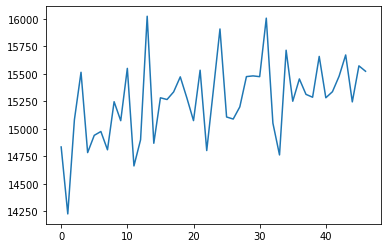

In [89]:
# Load summary

scores = np.concatenate((np.load('episode_20-score.npy'),np.load('episode_25 DeepQ_notExact-score.npy'))) 
plt.plot(scores)
plt.show()

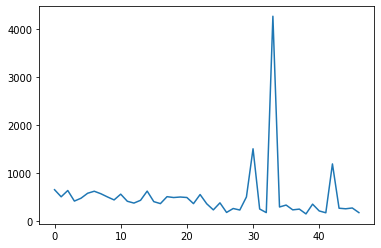

In [92]:
losses = np.concatenate((np.load('episode_20-loss.npy'),np.load('episode_25 DeepQ_notExact-loss.npy')))
plt.plot(losses)
plt.show()

## Improvments 

In [ ]:
## Improvments that could be implemented : 

# In the heuristic, weigth the probability that each car take a request between t and t + delta_t, and use that to have more accurate estimation
# Ranking of requests in the repositionnement
# Categorize requests for DistilQ into 4 category : (long and fast request) / (short and slow request) / (long and slow request) / (short and fast request) to make learning easier.
# Better deal with the overlap issue when assigning we want to assign 2 requests to a car!
# Do a pre-processing on the neighbours of every punkt of the grid to have better results in the heuristic (a long task) 
# We supose actually in the heuristic that cars in 104 don't exist between t and t + delta_t if there tasks aren't done but they can take requests! So that would be a good correction!
# Try : Discount_rate = 1.
# Make the Advantage work.